In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
from scipy import optimize

from scipy.spatial import procrustes
from matplotlib.colors import ListedColormap



import mnist_reader

X_train, y_train = mnist_reader.load_mnist('data/mnist', kind='train')
X_test, y_test = mnist_reader.load_mnist('data/mnist', kind='t10k')

n = X_train.shape[0]


X_train = X_train.astype(np.float32)
X_train = X_train/(np.max(X_train))
print(X_train.dtype)

classes = [
    '0',
    '1',
    '2',
    '3',
    '4',
    '5',
    '6',
    '7',
    '8',
    '9']

print(y_train)
print(X_train.shape, y_train.shape)

#set_up_parameters

epochs = 200
n_neighbors= 30
n_components = 2
MIN_DIST = 0.1
    
%matplotlib notebook

%load_ext autoreload
%autoreload 2

float32
[5 0 4 ... 5 6 8]
(60000, 784) (60000,)


In [2]:
import numba
from numba import prange

#@numba.jit(nopython=True)
def map_rotate(y, rot_angle):
    theta = (rot_angle) * np.pi / 180
    rot_mat = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])

    Y = y
    Y = rot_mat.dot(Y.T).T
    
    return Y

@numba.jit(nopython=True, parallel=True)
def get_first_order_graph(X,n_neighbors):
    
    N = X.shape[0]
    
    dist = np.zeros((N, N), dtype=np.float32)
    #euclidean_distances(X_train, squared = False)

    sort_idx = np.zeros((N,n_neighbors), dtype=np.int32)
    
    for i in range(N):
        if (i+1)%10000 == 0:
            print('Completed ', i+1, ' of ', N)
        
        for j in prange(i+1,N):
            dist[i,j] = np.sum( (X[i]-X[j])**2 )
            dist[j,i] = dist[i,j]
        
        sort_idx[i,:] = np.argsort(dist[i,:])[1:n_neighbors+1]
    
    return sort_idx, dist

@numba.jit(nopython=True, parallel=True)
def my_trustworthiness(Y,sort_idx,K):
    N = Y.shape[0]

    val = 0.0
    for i in prange(N):
        dist = np.sum((Y - Y[i,:])**2,axis=1)
        
        #print(dist.shape)
        
        sort_idy = np.argsort(dist)[1:]
        for j in prange(K):
            r_0 = np.argwhere(sort_idy[j]==sort_idx[i,:])
            #print(i, r_0, sort_idx[i,j])
            #print(sort_idy)
            r = r_0[0,0] 
            #print(i,r)
            #print(sort_idx[i,j])
            #print(sort_idy)
            r_v = r - K + 1
            if r_v>0:
                val += r_v
        #print(val)
    #print(val)
    val = val * 2.0 / ( N*K * (2*N - 3*K - 1.0))
    
    #print(val)
    
    return 1 - val


In [3]:
np.random.seed(23423)

rand_perm = np.random.permutation(n)

X_train_rp = X_train[rand_perm]
y_train_rp = y_train[rand_perm]

nA = 10000
nB = 25000
nC = 25000

SETA = X_train_rp[:nA]
y_SETA = y_train_rp[:nA]
SETB = X_train_rp[nA:nA+nB]
y_SETB = y_train_rp[nA:nA+nB]
SETC = X_train_rp[nA+nB:nA+nB+nC]
y_SETC = y_train_rp[nA+nB:nA+nB+nC]

data1 = np.concatenate((SETA, SETB))
data2 = np.concatenate((SETA, SETC))


print(SETA.shape, SETB.shape, SETC.shape)

(10000, 784) (25000, 784) (25000, 784)


In [4]:
Com_set = np.concatenate((SETA,SETB,SETC))
y_com_set = np.concatenate((y_SETA, y_SETB, y_SETC))

sort_idx, dist = get_first_order_graph(Com_set,n_neighbors=Com_set.shape[0]-1)

sort_idx_1, _ = get_first_order_graph(data1,n_neighbors=data1.shape[0]-1)
sort_idx_2, _ = get_first_order_graph(data2,n_neighbors=data2.shape[0]-1)

/home/ponir/pyTorch1.9/lib/python3.6/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


Completed  10000  of  60000
Completed  20000  of  60000
Completed  30000  of  60000
Completed  40000  of  60000
Completed  50000  of  60000
Completed  60000  of  60000
Completed  10000  of  35000
Completed  20000  of  35000
Completed  30000  of  35000
Completed  10000  of  35000
Completed  20000  of  35000
Completed  30000  of  35000


/home/ponir/pyTorch1.9/lib/python3.6/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


<IPython.core.display.Javascript object>


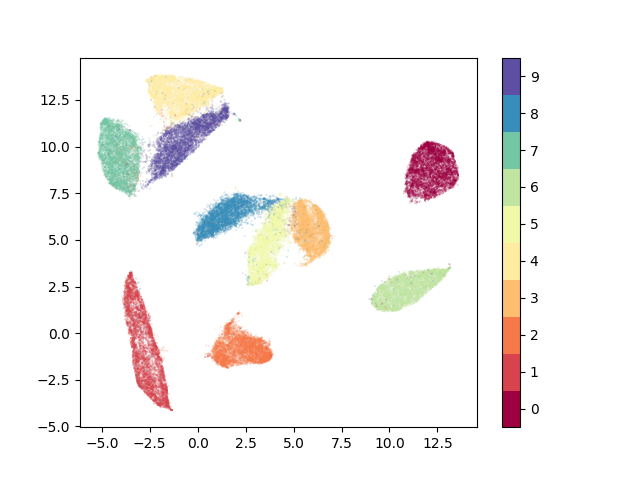

In [5]:
import umap

np.random.seed(100)
ump = umap.UMAP(n_neighbors=n_neighbors,
        min_dist=MIN_DIST,
        n_components=n_components,
        random_state=100,
        metric= 'precomputed')

y_umap_mapper = ump.fit(dist)
y_umap = y_umap_mapper.embedding_

plt.figure()
plt.scatter(y_umap[:,0], y_umap[:,1], c=y_com_set, s=0.01, cmap='Spectral')

cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)

<IPython.core.display.Javascript object>


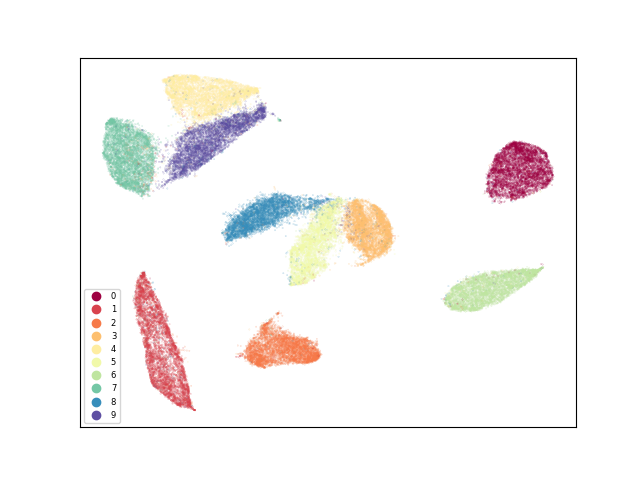

In [6]:
fig = plt.figure()
scatter = plt.scatter(y_umap[:,0], y_umap[:,1], c=y_com_set, s=0.01, marker='o', cmap='Spectral')
#scatter = plt.plot(y_umap[:,0], y_umap[:,1], c=y_com_set, ms=0.1, marker='o', cmap='Spectral')

plt.xticks([],[])
plt.yticks([],[])


lgd = plt.legend(*scatter.legend_elements(),
                    loc="lower left",
                    fontsize=12,
                prop={'size': 6})
for i in range(len(lgd.get_texts())):
    lgd.get_texts()[i].set_text(classes[i]) #PA
#lgd.get_texts()[1].set_text(r'$|\mathcal{D}^{(0)}|\in |D^{(2)}|$') #AP

plt.savefig('fmnist_figures/UMAP_whole.png', dpi=fig.dpi, bbox_inches='tight')

In [7]:
k_nn = 5

T1_raw = my_trustworthiness(y_umap,sort_idx,k_nn)

print(T1_raw)

0.9573399488820732


In [8]:
with open('MNIST_rawUMAP.npy', 'rb') as f:
    embA_raw = np.load(f)
    embA_C_raw = np.load(f)
    embB_raw = np.load(f)
    embC_raw = np.load(f)
    

(20000, 2) (20000,)


<IPython.core.display.Javascript object>


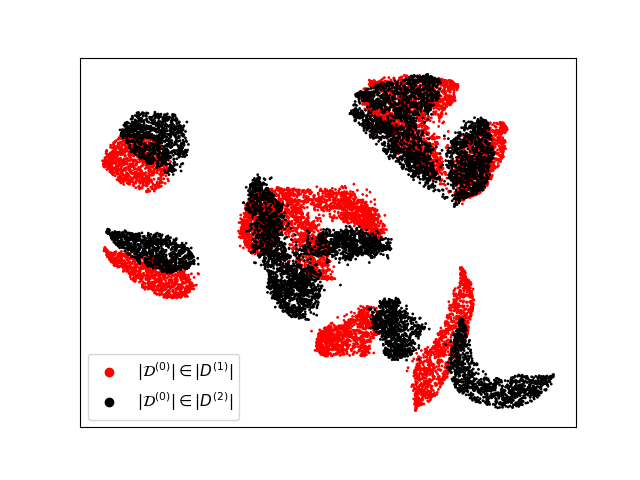

In [27]:
from scipy.spatial import procrustes

#mtx1, mtx2, d = procrustes(embA_raw, embA_C_raw)


#D1_raw = np.concatenate((mtx1, mtx2))
D1_raw = np.concatenate((embA_raw, embA_C_raw))
y_D1 = np.concatenate((np.zeros(y_SETA.shape[0]),np.ones(y_SETA.shape[0])))
y_D1_text = np.concatenate((['r']*embA_raw.shape[0], ['k']*embA_C_raw.shape[0]))

print(D1_raw.shape, y_D1.shape)

cmp = ListedColormap(['r', 'b'])
red = np.array([227,38,54])/255.0
blue = np.array([0,51,102])/255.0
cmp = ListedColormap(['r','k'])

plt.figure()
scatter = plt.scatter(D1_raw[:,0], D1_raw[:,1], c=y_D1, s=1, cmap=cmp)

plt.xticks([],[])
plt.yticks([],[])



lgd = plt.legend(*scatter.legend_elements(),
                    loc="lower left",
                    fontsize=11)
lgd.get_texts()[0].set_text(r'$|\mathcal{D}^{(0)}|\in |D^{(1)}|$') #PA
lgd.get_texts()[1].set_text(r'$|\mathcal{D}^{(0)}|\in |D^{(2)}|$') #AP

plt.savefig('fmnist_figures/D0D0fig_umap_raw.png', dpi=400, bbox_inches='tight')

<IPython.core.display.Javascript object>


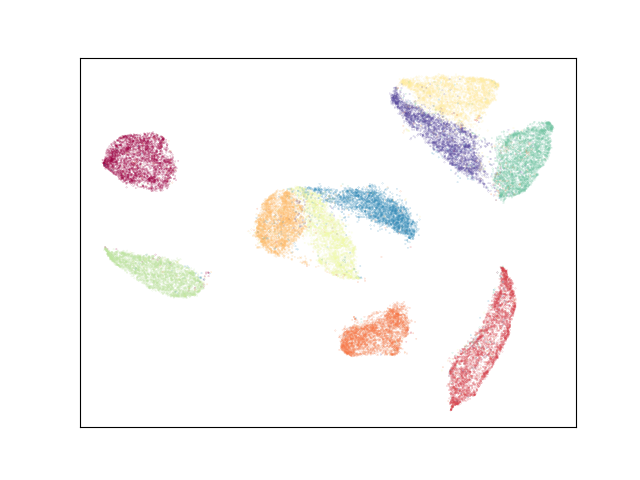

<IPython.core.display.Javascript object>


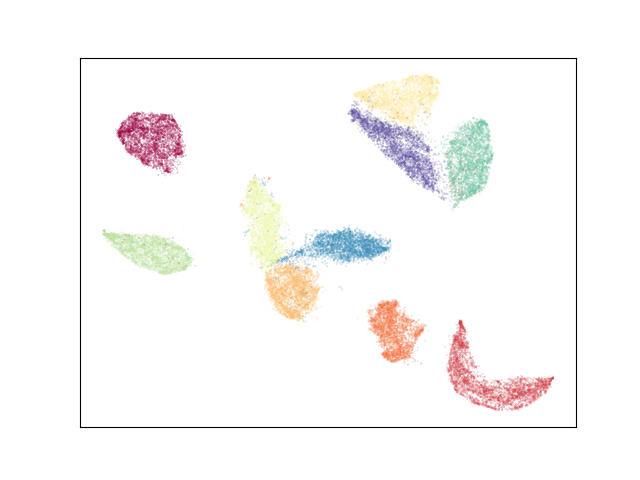

In [10]:
emb_set1 = np.concatenate((embA_raw, embB_raw))
y_emb_set1 = np.concatenate((y_SETA, y_SETB))


plt.figure()
#plt.title('EM_SET_1')
plt.scatter(emb_set1[:,0], emb_set1[:,1], c=y_emb_set1, s=0.01, cmap='Spectral')
plt.xticks([],[])
plt.yticks([],[])

#plt.xlim([-3.5, 16.7])
#plt.ylim([-4.25, 13.15])

#cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
#cbar.set_ticks(np.arange(10))
#cbar.set_ticklabels(classes)

plt.savefig('fmnist_figures/raw_umap_1.png', dpi=fig.dpi, bbox_inches='tight')

emb_set2 = np.concatenate((embA_C_raw,embC_raw))
y_emb_set2 = np.concatenate((y_SETA,y_SETC))


plt.figure()
#plt.title('EM_SET_2')
plt.scatter(emb_set2[:,0], emb_set2[:,1], c=y_emb_set2, s=0.01, cmap='Spectral')
plt.xticks([],[])
plt.yticks([],[])

#plt.xlim([-3.5, 16.7])
#plt.ylim([-4.25, 13.15])

#cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
#cbar.set_ticks(np.arange(10))
#cbar.set_ticklabels(classes)

plt.savefig('fmnist_figures/raw_umap_2.png', dpi=fig.dpi, bbox_inches='tight')

In [11]:
print(embA_raw.shape, embB_raw.shape)

k_nn = 5

T1_raw = my_trustworthiness(np.concatenate((embA_raw,embB_raw,embC_raw)),sort_idx,k_nn)
T2_raw = my_trustworthiness(np.concatenate((embA_C_raw,embB_raw,embC_raw)),sort_idx,k_nn)

print(T1_raw, T2_raw)

Td1_raw = my_trustworthiness(np.concatenate((embA_raw,embB_raw)),sort_idx_1,k_nn)
Td2_raw = my_trustworthiness(np.concatenate((embA_C_raw,embC_raw)),sort_idx_2,k_nn)
print(Td1_raw, Td2_raw)

D = procrustes(embA_raw, embA_C_raw)

print(np.sqrt(D[2]))

(10000, 2) (25000, 2)
0.927080702760368 0.9269902710361382
0.9569858454177281 0.958247690574172
0.3458297131695586


In [12]:
with open('MNIST_AlignedUMAP.npy', 'rb') as f:
    embA_aligned = np.load(f)
    embA_C_aligned = np.load(f)
    embB_aligned = np.load(f)
    embC_aligned = np.load(f)

<IPython.core.display.Javascript object>


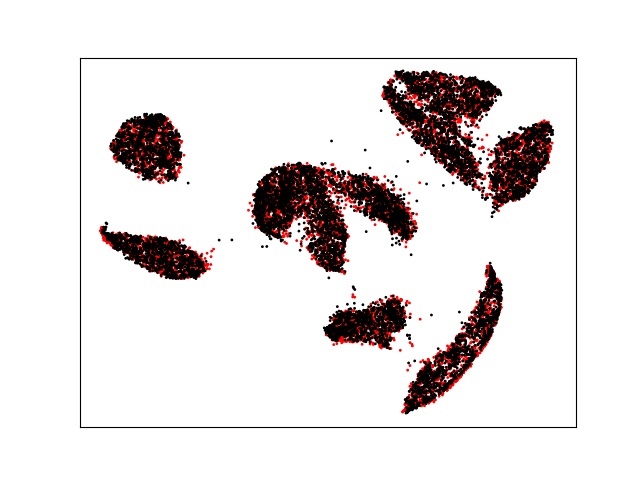

In [13]:
'''
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

D1_raw = np.concatenate((embA_aligned,embB_aligned))
zeros_raw = np.zeros((D1_raw.shape[0],1))
D1_raw = np.concatenate((D1_raw,zeros_raw),axis=1)
print(D1_raw.shape, zeros_raw.shape)
y_D1 = np.concatenate((y_SETA,y_SETB))

D2_raw = np.concatenate((embA_C_aligned,embC_aligned))
ones_raw = 0.1 * np.ones((D2_raw.shape[0],1))
D2_raw = np.concatenate((D2_raw, ones_raw), axis=1)
y_D2 = np.concatenate((y_SETA, y_SETC))

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(D1_raw[:,0],D1_raw[:,1],D1_raw[:,2],c=y_D1, s=0.01, cmap='Spectral')
ax.scatter(D2_raw[:,0], D2_raw[:,1], D2_raw[:,2], c=y_D2, s=0.01, cmap='Spectral')

idxs = np.random.choice(len(SETA), 50, replace=False)

for i in range(len(idxs)):
    ax.plot3D([D1_raw[idxs[i],0], D2_raw[idxs[i],0]], 
              [D1_raw[idxs[i],1], D2_raw[idxs[i],1]],
              [D1_raw[idxs[i],2], D2_raw[idxs[i],2]], color='grey')
'''

D1_aligned = np.concatenate((embA_aligned, embA_C_aligned))
y_D1 = np.concatenate((np.zeros(y_SETA.shape[0]),np.ones(y_SETA.shape[0])))

cmp = ListedColormap(['r', 'b'])
red = np.array([227,38,54])/255.0
blue = np.array([0,51,102])/255.0
cmp = ListedColormap(['r','k'])

plt.figure()
scatter = plt.scatter(D1_aligned[:,0], D1_aligned[:,1], c=y_D1, s=1, cmap=cmp)

#plt.axis('off')
plt.xticks([],[])
plt.yticks([],[])

plt.xlim([-10.25, 8.3])
plt.ylim([-10.1, 7.15])

#lgd = plt.legend(*scatter.legend_elements(),
#                    loc="lower left",
#                    fontsize=12)
#lgd.get_texts()[0].set_text('        ') #PA
#lgd.get_texts()[1].set_text('        ') #AP

plt.savefig('fmnist_figures/D0D0_fig_aligned_umap.png', dpi=400, bbox_inches='tight')

<IPython.core.display.Javascript object>


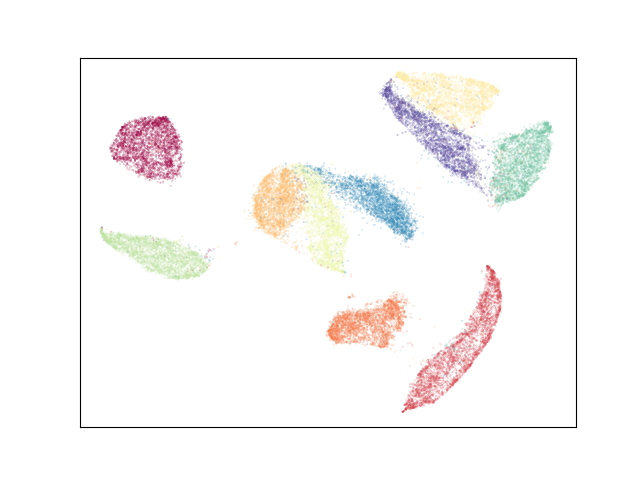

<IPython.core.display.Javascript object>


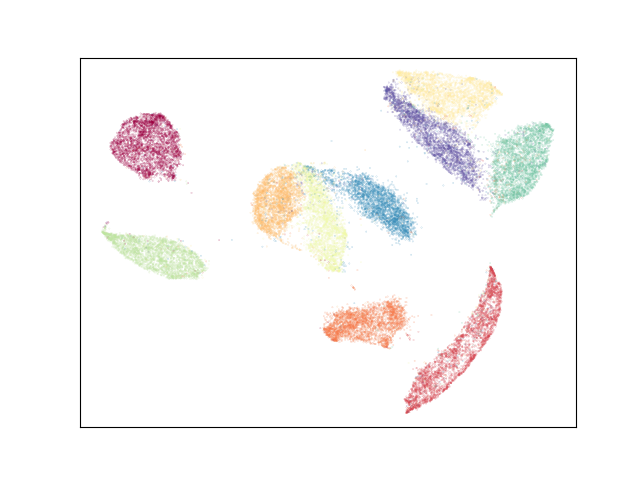

In [14]:
emb_set1 = np.concatenate((embA_aligned, embB_aligned))
y_emb_set1 = np.concatenate((y_SETA, y_SETB))


plt.figure()
#plt.title('EM_SET_1')
plt.scatter(emb_set1[:,0], emb_set1[:,1], c=y_emb_set1, s=0.01, cmap='Spectral')
plt.xticks([],[])
plt.yticks([],[])

plt.xlim([-10.25, 8.3])
plt.ylim([-10.1, 7.15])

#cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
#cbar.set_ticks(np.arange(10))
#cbar.set_ticklabels(classes)

plt.savefig('fmnist_figures/aligned_umap_1.png', dpi=fig.dpi, bbox_inches='tight')

emb_set2 = np.concatenate((embA_C_aligned,embC_aligned))
y_emb_set2 = np.concatenate((y_SETA,y_SETC))


plt.figure()
#plt.title('EM_SET_2')
plt.scatter(emb_set2[:,0], emb_set2[:,1], c=y_emb_set2, s=0.01, cmap='Spectral')
plt.xticks([],[])
plt.yticks([],[])

plt.xlim([-10.25, 8.3])
plt.ylim([-10.1, 7.15])

#cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
#cbar.set_ticks(np.arange(10))
#cbar.set_ticklabels(classes)

plt.savefig('fmnist_figures/aligned_umap_2.png', dpi=fig.dpi, bbox_inches='tight')

In [15]:
T1_aligned = my_trustworthiness(np.concatenate((embA_aligned,embB_aligned,embC_aligned)),sort_idx,k_nn)
T2_aligned = my_trustworthiness(np.concatenate((embA_C_aligned,embB_aligned,embC_aligned)),sort_idx,k_nn)

print(T1_aligned, T2_aligned)

Td1_aligned = my_trustworthiness(np.concatenate((embA_aligned,embB_aligned)),sort_idx_1,k_nn)
Td2_aligned = my_trustworthiness(np.concatenate((embA_C_aligned,embC_aligned)),sort_idx_2,k_nn)
print(Td1_aligned, Td2_aligned)

D = procrustes(embA_aligned, embA_C_aligned)

print(np.sqrt(D[2]))

0.9549611702115838 0.954962182513224
0.9567771809066562 0.9570112745770462
0.042087181523861227


In [16]:
with open('MNIST_Aligned_NE_10_25_25.npy', 'rb') as f:
    embA_ne = np.load(f)
    embB_ne = np.load(f)
    embC_ne = np.load(f)

<IPython.core.display.Javascript object>


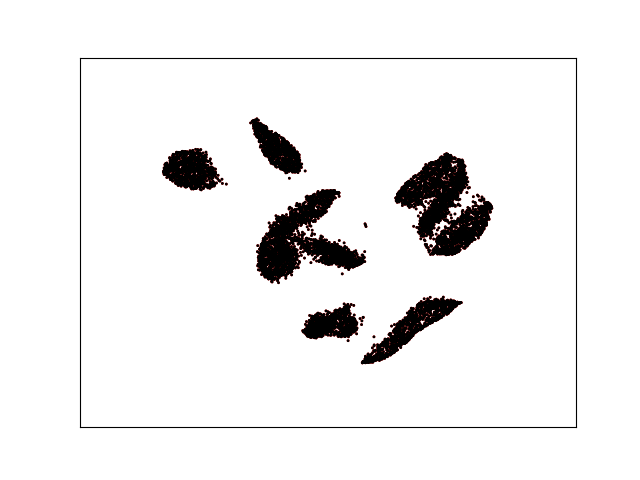

In [17]:
D1_ne = np.concatenate((embA_ne, embA_ne))
D1_ne = map_rotate(D1_ne, rot_angle=-40)
y_D1 = np.concatenate((np.zeros(y_SETA.shape[0]),np.ones(y_SETA.shape[0])))

cmp = ListedColormap(['r', 'b'])
red = np.array([227,38,54])/255.0
blue = np.array([0,51,102])/255.0
cmp = ListedColormap(['r','k'])

plt.figure()
scatter = plt.scatter(-D1_ne[:,0], -D1_ne[:,1], c=y_D1, s=1, cmap=cmp)

#plt.axis('off')
plt.xticks([],[])
plt.yticks([],[])

plt.xlim([-13.3, 11.9])
plt.ylim([-12.30, 10.1])

#lgd = plt.legend(*scatter.legend_elements(),
#                    loc="lower left",
#                    fontsize=12)
#lgd.get_texts()[0].set_text('        ') #PA
#lgd.get_texts()[1].set_text('        ') #AP

plt.savefig('fmnist_figures/D0D0fig_umap_mane.png', dpi=400, bbox_inches='tight')

<IPython.core.display.Javascript object>


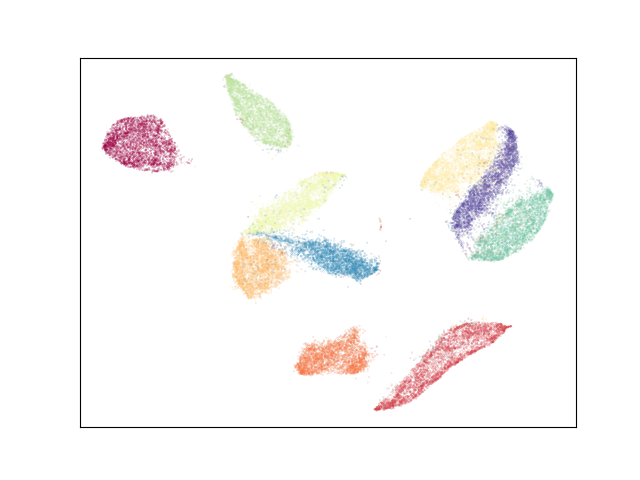

<IPython.core.display.Javascript object>


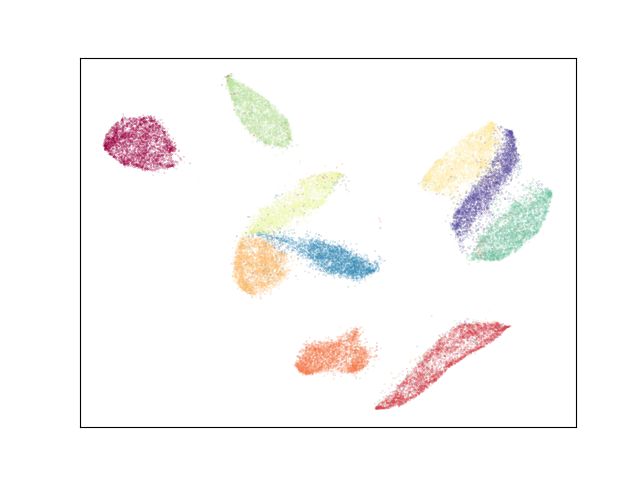

In [21]:
emb_set1 = np.concatenate((embA_ne, embB_ne))
emb_set1 = map_rotate(emb_set1, rot_angle=-40)
y_emb_set1 = np.concatenate((y_SETA, y_SETB))


plt.figure()
#plt.title('EM_SET_1')
plt.scatter(-emb_set1[:,0], -emb_set1[:,1], c=y_emb_set1, s=0.01, cmap='Spectral')
plt.xticks([],[])
plt.yticks([],[])

plt.xlim([-9.95, 8.50])
plt.ylim([-9.20, 7.1])

#cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
#cbar.set_ticks(np.arange(10))
#cbar.set_ticklabels(classes)

plt.savefig('fmnist_figures/ne_umap_1.png', dpi=fig.dpi, bbox_inches='tight')

emb_set2 = np.concatenate((embA_ne, embC_ne))
emb_set2 = map_rotate(emb_set2, rot_angle=-40)
y_emb_set2 = np.concatenate((y_SETA,y_SETC))


plt.figure()
#plt.title('EM_SET_2')
plt.scatter(-emb_set2[:,0], -emb_set2[:,1], c=y_emb_set2, s=0.01, cmap='Spectral')
plt.xticks([],[])
plt.yticks([],[])

plt.xlim([-9.95, 8.50])
plt.ylim([-9.20, 7.1])

#cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
#cbar.set_ticks(np.arange(10))
#cbar.set_ticklabels(classes)

plt.savefig('fmnist_figures/ne_umap_2.png', dpi=fig.dpi, bbox_inches='tight')

In [19]:
T1_ne = my_trustworthiness(np.concatenate((embA_ne,embB_ne,embC_ne)),sort_idx,k_nn)

print(T1_ne)

Td1_ne = my_trustworthiness(np.concatenate((embA_ne,embB_ne)),sort_idx_1,k_nn)
Td2_ne = my_trustworthiness(np.concatenate((embA_ne,embC_ne)),sort_idx_2,k_nn)
print(Td1_ne, Td2_ne)


0.9531873644819309
0.953641512835587 0.9542083736690835


In [20]:
from sklearn.manifold import trustworthiness

choices = np.random.choice(len(X_train_rp),size=2000, replace=False)

Xh = X_train_rp[choices]
Yh = np.concatenate((embA_ne,embB_ne,embC_ne))[choices]

n_neib = 5

sort_idx_xh, _ = get_first_order_graph(Xh,n_neighbors=Xh.shape[0]-1)
print(my_trustworthiness(Yh, sort_idx_xh, n_neib))
print(trustworthiness(Xh, Yh, n_neighbors=n_neib))

0.9482041666666666
0.9482041164658634
